In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import string, math
import matplotlib.pyplot as plt

# Dataset

In [2]:
class EngSpaDataset(Dataset):

    def __init__(self, csv_path, start_idx = 0, end_idx = None):
        self.df = self.read_df(csv_path, start_idx, end_idx)
        self.eng2idx, self.spa2idx, self.idx2spa = self.get_idx_mappings(self.df)

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, index):
        eng, spa = self.df.iloc[index]
        eng, spa = self.add_tokens(eng, spa)
        eng, spa = self.embed(eng, spa)
        return eng, spa[:-1],  spa[1:]

    def preprocess(self, text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    def read_df(self, csv_path, start_idx, end_idx):
        if end_idx is not None:
            df = pd.read_csv(csv_path).iloc[start_idx:end_idx]
        else:
            df = pd.read_csv(csv_path).iloc[start_idx:]
        return df

    def get_idx_mappings(self, df):
        spa2idx = {word: i + 3 for i, word in enumerate(sorted(list(set(" ".join(list(np.array(df[["SPA"]]).reshape(-1))).split()))))}
        eng2idx = {word: i + 1 for i, word in enumerate(sorted(list(set(" ".join(list(np.array(df[["ENG"]]).reshape(-1))).split()))))}
        spa2idx["<PAD>"] = 0
        spa2idx["<SOS>"] = 1
        spa2idx["<EOS>"] = 2
        eng2idx["<PAD>"] = 0
        idx2spa = {i: word for word, i in spa2idx.items()}
        return eng2idx, spa2idx, idx2spa


    def add_tokens(self, eng, spa):
        eng, spa = eng.split(), ["<SOS>"] + spa.split() + ["<EOS>"]
        return eng, spa

    def generate_mask(self, eng_len, spa_len):
        eng_mask = torch.cat([torch.ones(eng_len), torch.zeros(self.eng_max_len - eng_len)]) == 1
        spa_mask = torch.cat([torch.ones(spa_len), torch.zeros(self.spa_max_len - spa_len)]) == 1
        return eng_mask, spa_mask

    def embed(self, eng, spa):
        eng = torch.tensor([self.eng2idx[word] for word in eng])
        spa = torch.tensor([self.spa2idx[word] for word in spa])
        return eng, spa
    

def test_dataset():
    d = EngSpaDataset("eng-spa.csv")
    # loader = DataLoader(d, batch_size=32)
    encoder_input, decoder_input, target = d[9830]
    print(f"Encoder input shape: {encoder_input.shape}")
    print(f"Decoder input shape: {decoder_input.shape}")
    print(f"Target shape: {target.shape}")

test_dataset()

Encoder input shape: torch.Size([4])
Decoder input shape: torch.Size([5])
Target shape: torch.Size([5])


# Attention layers

In [3]:
class QKVLayer(nn.Module):

    def __init__(self, input_dim, output_dim, num_heads, mode="qkv"):
        super(QKVLayer, self).__init__()
        assert output_dim % num_heads == 0    # output_dim must be divisible by num_heads
        assert mode == "qkv" or mode == "kv" or mode == "q"
        self.len_mode = len(mode)
        self.num_heads, self.head_dim = num_heads, output_dim // num_heads
        self.qkv_linear = nn.Linear(input_dim, output_dim * self.len_mode)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        qkv = self.qkv_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim * self.len_mode)
        qkv = qkv.permute(0, 2, 1, 3)
        return qkv.chunk(self.len_mode, dim=-1)
    

class ScaledDotProductAttention(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    # mask must be of shape [batch_size, num_heads, seq_len, seq_len]
    # mask must combine no peek mask and padding mask
    def forward(self, q, k, v, mask):
        d_k = k.shape[-1]
        qk = q.matmul(k.transpose(-1, -2)) / d_k
        if mask is not None:
            qk = qk.masked_fill(~mask, -torch.inf)
        attn_weights = qk.softmax(dim=-1)
        return attn_weights.matmul(v)
    

# if encoder_kv is true, forward call expects x values and outputs from encoder block
# queries generated from x values and k, v generated from encoder outputs to attend to
class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, output_dim, num_heads, encoder_kv=False) -> None:
        super(MultiHeadAttention, self).__init__()
        self.encoder_kv = encoder_kv
        if not encoder_kv:
            self.qkv_layer = QKVLayer(input_dim, output_dim, num_heads)
        else:
            self.q_layer = QKVLayer(input_dim, output_dim, num_heads, mode="q")
            self.kv_layer = QKVLayer(input_dim, output_dim, num_heads, mode="kv")
        self.attention = ScaledDotProductAttention()
        self.out_proj = nn.Linear(output_dim, output_dim)

    # mask must be of shape [batch_size, num_heads, seq_len, seq_len], combining padding and no peek mask
    # x of shape [batch_size, seq_len, embed_dim]
    # enc_outputs of shape [batch_size, seq_len2, embed_dim]
    def forward(self, x, enc_outputs=None, mask=None):
        batch_size, seq_len, _ = x.shape

        if not self.encoder_kv:
            q, k, v = self.qkv_layer(x)
        else:
            assert enc_outputs is not None and mask is None
            q = self.q_layer(x)[0]
            k, v = self.kv_layer(enc_outputs)

        attn_outputs = self.attention(q, k, v, mask)
        return self.out_proj(attn_outputs.permute(0, 2, 1, 3).reshape(batch_size, seq_len, -1))
    

def test_multi_head_attention():
    mha = MultiHeadAttention(512, 512, 8)
    mha_with_enc_att = MultiHeadAttention(512, 512, 8, encoder_kv=True)

    x = torch.randn(32, 100, 512)
    mask = torch.ones(32, 8, 100, 100).type(torch.bool)
    enc_out = torch.randn(32, 1048, 512)

    out1 = mha(x, mask=mask)
    out2 = mha_with_enc_att(out1, enc_outputs=enc_out)
    print(out1.shape)
    print(out2.shape)

test_multi_head_attention()

torch.Size([32, 100, 512])
torch.Size([32, 100, 512])


# Positionwise Feed Forward and Positional Encoding

torch.Size([32, 100, 512])


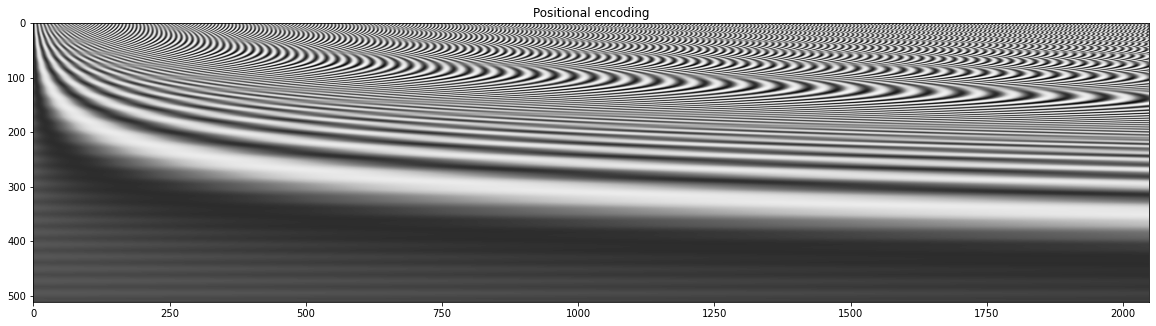

In [4]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model, max_seq_len, p=0.1):
        super(PositionalEncoder, self).__init__()
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=p)

    # x has shape [batch, seq_len, embed_dim]
    def forward(self, x):
        _, seq_len, _ = x.shape
        return self.dropout(x + self.pe[:, :seq_len, :])
    

class FeedForward(nn.Module):

    def __init__(self, input_dim):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim * 4),
            nn.ReLU(),
            nn.Linear(input_dim * 4, input_dim)
        )

    def forward(self, x):
        return self.layer(x)
    

def test_positional_encoder():
    pe = PositionalEncoder(512, 2048)
    out = pe(torch.randn(32, 100, 512))
    print(out.shape)
    plt.figure(figsize=(20, 10))
    plt.title("Positional encoding")
    plt.imshow(pe.pe[0].T, cmap="Greys")

test_positional_encoder()

# Transformer Encoder

In [5]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(input_dim, input_dim, num_heads)
        self.layer_norm1 = nn.LayerNorm(input_dim)
        self.feed_forward = FeedForward(input_dim)
        self.layer_norm2 = nn.LayerNorm(input_dim)

    def forward(self, x, mask=None):
        skip_x = x
        x = self.mha(x, mask=mask)
        x = self.layer_norm1(x + skip_x)
        skip_x = x
        x = self.feed_forward(x)
        return self.layer_norm2(x + skip_x)
    

class TransformerEncoder(nn.Module):

    def __init__(self, input_dim, d_model, num_heads, n_layers, max_seq_len=4096):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(input_dim, d_model)
        self.pos_enc = PositionalEncoder(d_model, max_seq_len)
        self.encoder_layers = nn.ModuleList([TransformerEncoderBlock(d_model, num_heads) for _ in range(n_layers)])
        
    def forward(self, x, mask):
        x = self.pos_enc(self.embed(x) * math.sqrt(self.d_model))
        for layer in self.encoder_layers:
            x = layer(x, mask)
        return x
    

def test_transformer_encoder():
    encoder = TransformerEncoder(5000, 512, 8, 3).to("mps")
    x = torch.arange(0, 100).view(1, 100).repeat(32, 1).to("mps")
    mask = torch.ones(32, 8, 100, 100).type(torch.bool).to("mps")
    out = encoder(x, mask)
    print(out.shape)

test_transformer_encoder()

torch.Size([32, 100, 512])


# Transformer Decoder

In [6]:
class TransformerDecoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads):
        super(TransformerDecoderBlock, self).__init__()
        self.masked_mha = MultiHeadAttention(input_dim, input_dim, num_heads)
        self.layer_norm1 = nn.LayerNorm(input_dim)
        self.encoder_mha = MultiHeadAttention(input_dim, input_dim, num_heads, encoder_kv=True)
        self.layer_norm2 = nn.LayerNorm(input_dim)
        self.feed_forward = FeedForward(input_dim)
        self.layer_norm3 = nn.LayerNorm(input_dim)

    def forward(self, x, enc_outputs, mask):
        skip_x = x
        x = self.masked_mha(x, mask=mask)
        x = self.layer_norm1(x + skip_x)
        skip_x = x
        x = self.encoder_mha(x, enc_outputs=enc_outputs)
        x = self.layer_norm2(x + skip_x)
        skip_x = x
        x = self.feed_forward(x)
        x = self.layer_norm3(x + skip_x)
        return x
    

class TransformerDecoder(nn.Module):

    def __init__(self, input_dim, d_model, num_heads, n_layers, max_seq_len=4096):
        super(TransformerDecoder, self).__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(input_dim, d_model)
        self.pos_enc = PositionalEncoder(d_model, max_seq_len)
        self.decoder_layers = nn.ModuleList([TransformerDecoderBlock(d_model, num_heads) for _ in range(n_layers)])
        self.out_proj = nn.Linear(d_model, input_dim, bias=False)
        self.out_proj.weight = self.embed.weight

    def forward(self, x, enc_outputs, mask):
        x = self.pos_enc(self.embed(x) * math.sqrt(self.d_model))
        for layer in self.decoder_layers:
            x = layer(x, enc_outputs, mask)
        return self.out_proj(x)
    

def test_transformer_decoder():
    decoder = TransformerDecoder(5000, 512, 8, 5).to("mps")
    x = torch.arange(0, 100).unsqueeze(0).repeat(32, 1).to("mps")
    mask = torch.ones(32, 8, 100, 100).type(torch.bool).to("mps")
    enc_out = torch.randn(32, 1048, 512).to("mps")
    out = decoder(x, enc_out, mask)
    print(out.shape)

test_transformer_decoder()

torch.Size([32, 100, 5000])


# Transformer model

In [7]:
class Seq2SeqTransformer(nn.Module):

    def __init__(self, src_dim, tgt_dim, d_model, num_heads, enc_layers, dec_layers):
        super(Seq2SeqTransformer, self).__init__()
        self.encoder = TransformerEncoder(
            input_dim=src_dim,
            d_model=d_model,
            num_heads=num_heads,
            n_layers=enc_layers
        )
        self.decoder = TransformerDecoder(
            input_dim=tgt_dim,
            d_model=d_model,
            num_heads=num_heads,
            n_layers=enc_layers
        )

    def forward(self, enc_input, dec_input, enc_mask, dec_mask):
        enc_outputs = self.encoder(enc_input, enc_mask)
        out = self.decoder(
            x=dec_input,
            enc_outputs=enc_outputs,
            mask=dec_mask
        )
        return out
    

def test_transformer():
    dev = torch.device("mps")
    batch_size = 32
    model = Seq2SeqTransformer(
        src_dim=4000,
        tgt_dim=6000,
        d_model=512,
        num_heads=8,
        enc_layers=3,
        dec_layers=3
    ).to(dev)
    src = torch.arange(0, 100).unsqueeze(0).repeat(batch_size, 1).to(dev)
    dec_input = torch.arange(0, 120).unsqueeze(0).repeat(batch_size, 1).to(dev)
    enc_mask = torch.ones(batch_size, 8, 100, 100).type(torch.bool).to(dev)
    dec_mask = torch.ones(batch_size, 8, 120, 120).type(torch.bool).to(dev)
    out = model(src, dec_input, enc_mask, dec_mask)
    print(out.shape)

test_transformer()

torch.Size([32, 120, 6000])


# Padding functions

In [8]:
class PadCollate:

    def __init__(self, dim=0):
        self.dim = dim

    def pad_tensor_gen_mask(self, vec, pad, dim):
        mask = torch.cat([torch.ones(vec.shape[dim]), torch.zeros(pad - vec.shape[dim])], dim=dim)
        return torch.cat([vec, torch.zeros(pad - vec.shape[dim]), mask], dim=dim)

    def __call__(self, batch):
        max_src_len = max(map(lambda x: x[0].shape[self.dim], batch))
        max_dec_len = max(map(lambda x: x[1].shape[self.dim], batch))
        batch = [(self.pad_tensor_gen_mask(x, max_src_len, 0), self.pad_tensor_gen_mask(y, max_dec_len, 0), self.pad_tensor_gen_mask(z, max_dec_len, 0)) for x, y, z in batch]
        src_and_mask = torch.stack([x[0] for x in batch], dim=0)
        dec_and_mask = torch.stack([x[1] for x in batch], dim=0)
        tgt_and_mask = torch.stack([x[2] for x in batch], dim=0)
        src, src_mask = src_and_mask.chunk(2, dim=-1)
        dec, dec_mask = dec_and_mask.chunk(2, dim=-1)
        tgt, _ = tgt_and_mask.chunk(2, dim=-1)
        return (src.type(torch.long), src_mask.type(torch.bool)), (dec.type(torch.long), dec_mask.type(torch.bool)), tgt.type(torch.long)
    

# padding_mask has shape [batch_size, seq_len]
def prepare_mask(padding_mask, num_heads, no_peek_future=False):
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(-2).repeat(1, num_heads, padding_mask.shape[-1], 1)
    if no_peek_future:
        no_peek_future = torch.tril(torch.ones(padding_mask.shape[-1], padding_mask.shape[-1])).type(torch.bool)
        padding_mask = padding_mask * no_peek_future
    return padding_mask


def test_padding():
    loader = DataLoader(EngSpaDataset("eng-spa.csv"), batch_size=32, shuffle=False, collate_fn=PadCollate())
    (src, src_mask), (dec_input, dec_mask), tgt = next(iter(loader))
    print(src[0])
    print(dec_input[0])
    print(tgt[0])
    src_mask = prepare_mask(src_mask, 8)
    dec_mask = prepare_mask(dec_mask, 8, no_peek_future=True)
    print(src_mask.shape, dec_mask.shape)
    print(src_mask[0][0])
    print(dec_mask[0][0])

test_padding()

tensor([5721])
tensor([    1, 26946,     0])
tensor([26946,     2,     0])
torch.Size([32, 8, 1, 1]) torch.Size([32, 8, 3, 3])
tensor([[True]])
tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True, False]])
